# Live Daten Montag bis Sonntag

In [1]:
from __future__ import unicode_literals
from IPython.display import display, HTML
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
import datetime
import common.live

In [2]:
#config
reload(sys)
sys.setdefaultencoding('utf-8')
plt.rcParams.update({'figure.max_open_warning': 0})
matplotlib.style.use('ggplot')
%matplotlib inline

#constants
LIVE_DATA_DIRECTORY = '/home/marcel/rbtv/rbtvdata/live'

In [3]:
#load live data
live = common.live.load(LIVE_DATA_DIRECTORY)

#create additional column
live['day'] = live.index.strftime('%Y-%m-%d')
live['weekday'] = live.index.dayofweek

## Auswertung 
___

,18:00 - 19:59,20:00 - 21:59,22:00 - 23:59
day,,,
2016-01-04,7381.758333,9838.991667,7924.975000
2016-01-11,6894.783333,10893.400000,9289.325000
2016-01-18,8144.083333,11969.825000,9482.041667
2016-01-25,8820.633333,14414.921739,9626.775000
2016-02-01,9378.658333,15181.525000,10914.733333
2016-02-08,8819.075000,15063.683333,10747.616667
2016-02-15,7803.875000,11117.041667,8713.591667
2016-02-22,8228.133333,10834.283333,8025.841667
2016-02-29,8580.383333,10807.141667,8289.700000


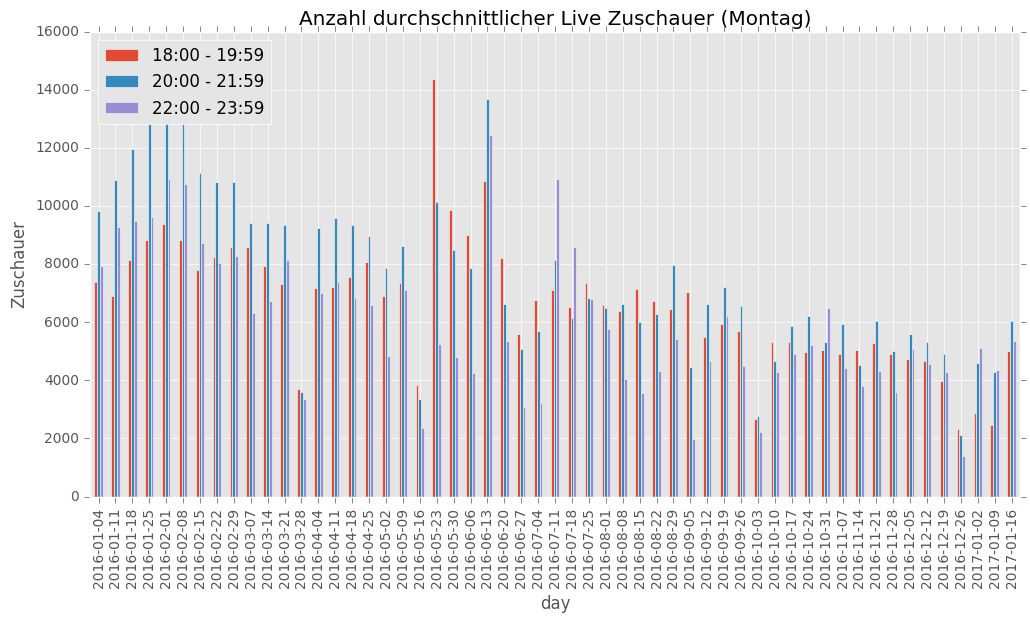

,18:00 - 19:59,20:00 - 21:59,22:00 - 23:59
day,,,
2016-01-05,5813.175000,6935.116667,5565.133333
2016-01-12,7539.458333,17306.016667,7890.900000
2016-01-19,6682.541667,16425.775000,8793.800000
2016-01-26,6930.166667,8980.383333,7286.666667
2016-02-02,6773.808333,15101.691667,7873.133333
2016-02-09,9692.475000,33965.841667,9419.375000
2016-02-16,7275.266667,15498.158333,6823.077586
2016-02-23,6670.750000,16020.016667,7843.466667
2016-03-01,6691.766667,27520.925000,7517.233333


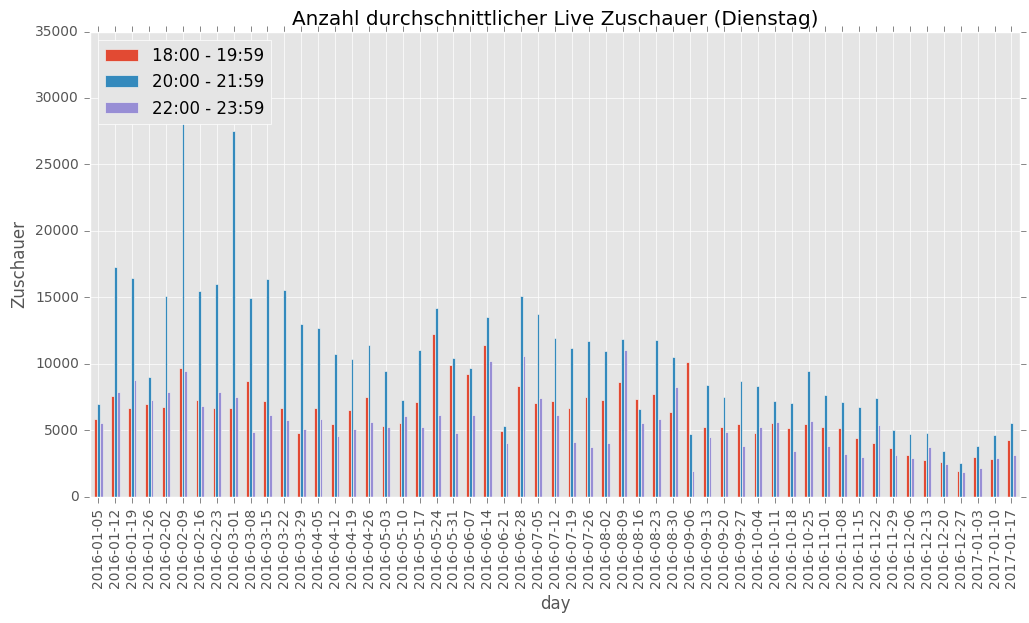

,18:00 - 19:59,20:00 - 21:59,22:00 - 23:59
day,,,
2016-01-06,7935.650000,13714.200000,8220.258333
2016-01-13,8942.575000,13911.300000,9177.108333
2016-01-20,6914.008333,14822.591667,10001.291667
2016-01-27,7442.116667,14205.891667,8614.133333
2016-02-03,7167.083333,14429.616667,8305.958333
2016-02-10,7187.591667,14750.525000,10209.808333
2016-02-17,7579.175000,13507.758333,7779.391667
2016-02-24,5992.100000,13867.958333,9604.200000
2016-03-02,6023.716667,12004.584071,8510.041667


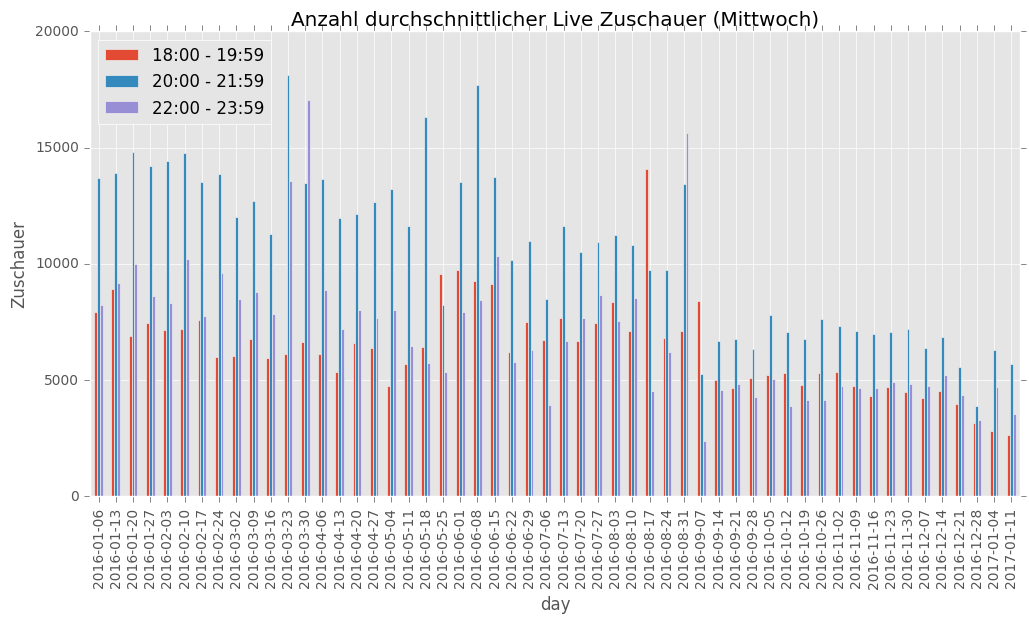

,18:00 - 19:59,20:00 - 21:59,22:00 - 23:59
day,,,
2016-01-07,6019.458333,9908.541667,7632.858333
2016-01-14,6785.533333,11607.858333,7884.000000
2016-01-21,7280.458333,10651.958333,8022.691667
2016-01-28,7014.750000,10701.883333,8449.033333
2016-02-04,6413.958333,9830.566667,6906.441667
2016-02-11,6444.491667,10476.675000,7321.400000
2016-02-18,7538.525000,14441.100000,10212.025000
2016-02-25,6901.208333,9787.350000,6656.441667
2016-03-03,6611.091667,9389.108333,6392.275000


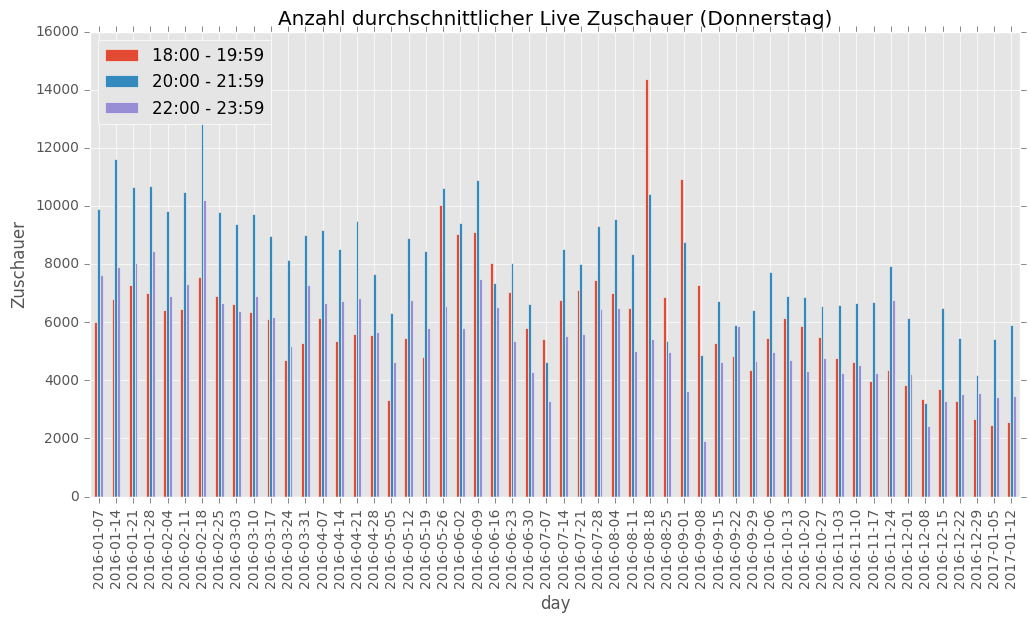

,18:00 - 19:59,20:00 - 21:59,22:00 - 23:59
day,,,
2016-01-01,3213.666667,3260.325000,2602.800000
2016-01-08,8874.041667,8698.466667,8206.083333
2016-01-15,10505.400000,18595.808333,13322.691667
2016-01-22,9975.883333,7482.416667,8084.408333
2016-01-29,5798.616667,5952.208333,5698.891667
2016-02-05,5445.991667,6448.141667,5910.383333
2016-02-12,9134.233333,14424.308333,7217.850000
2016-02-19,6374.658333,6094.841667,5389.300000
2016-02-26,5390.541667,8095.158333,6457.125000


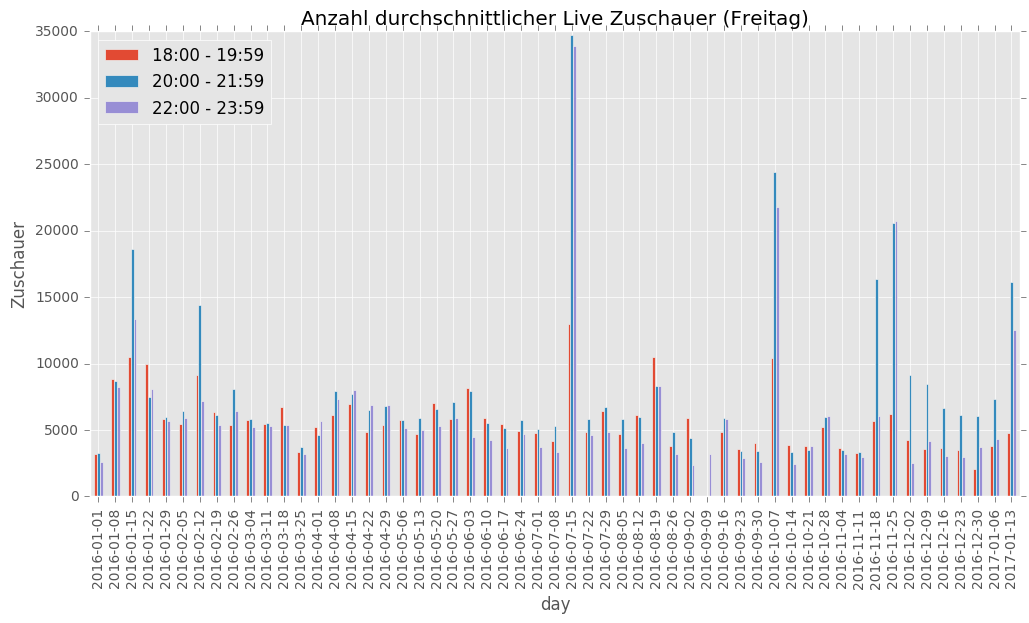

,18:00 - 19:59,20:00 - 21:59,22:00 - 23:59
day,,,
2016-01-02,3753.883333,3337.400000,2840.100000
2016-01-09,4197.125000,6150.900000,5634.266667
2016-01-16,5248.033333,7619.725000,5861.108333
2016-01-23,8783.208333,8790.191667,6759.708333
2016-01-30,4742.583333,6879.283333,5678.141667
2016-02-06,4183.391667,6278.816667,5706.858333
2016-02-13,4541.725000,7077.383333,6194.116667
2016-02-20,4392.425000,6831.633333,5925.641667
2016-02-27,3666.566667,6192.891667,4228.225000


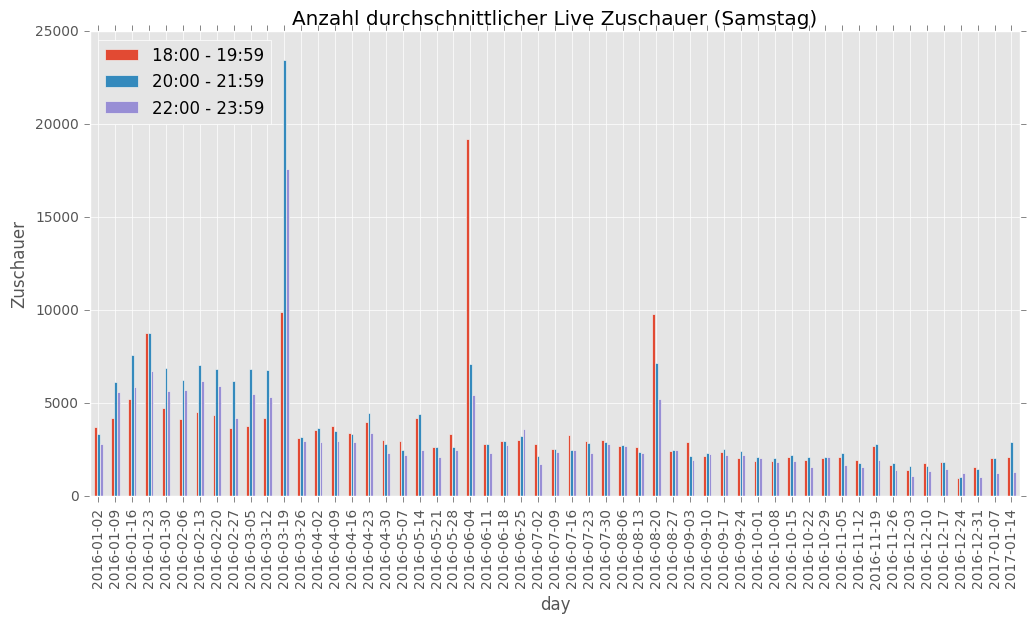

,18:00 - 19:59,20:00 - 21:59,22:00 - 23:59
day,,,
2016-01-03,3697.050000,4595.083333,3530.991667
2016-01-10,5764.850000,5426.625000,3987.325000
2016-01-17,5452.908333,5525.025000,5296.525000
2016-01-24,6273.416667,6098.550000,3933.925000
2016-01-31,4615.933333,5300.408333,3673.600000
2016-02-07,5243.600000,4880.316667,3177.875000
2016-02-14,4558.058333,5440.108333,6188.916667
2016-02-21,4958.458333,4990.616667,3007.591667
2016-02-28,3953.566667,5678.191176,12928.458333


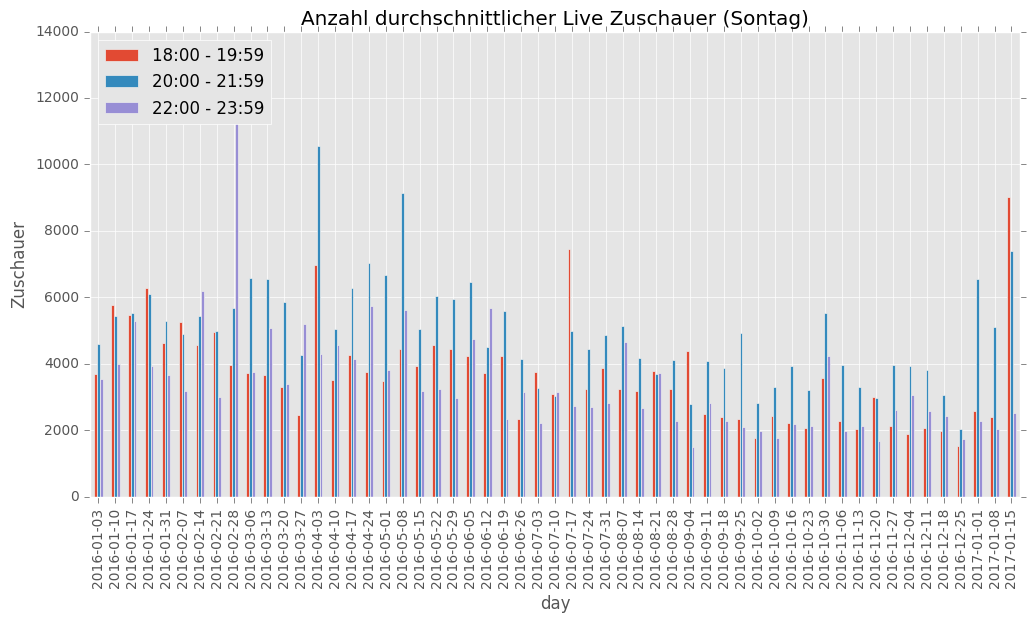

In [4]:
#filter data by date
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime.now()
liveFiltered = live.loc[start : end]

weekdayNames = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sontag']

dataMonthly = []
for i in range(0, 7):
    #filter data by weekday
    liveFilteredWeekday = liveFiltered[liveFiltered['weekday'] == i]
    
    dataMonthly.append({})

    #filter data by time
    rangeStart = datetime.time(18, 0, 0)
    rangeEnd = datetime.time(19, 59, 59)
    until = datetime.time(0, 0, 0)
    data = pd.DataFrame({})
    for j in range(0, 3):
        rangeStr = rangeStart.strftime('%H:%M') + ' - ' + rangeEnd.strftime('%H:%M')

        dataMonthly[i][rangeStr] = pd.DataFrame()

        #filter data by time
        liveFilteredTime = liveFilteredWeekday.between_time(rangeStart, rangeEnd)

        #group messages by date
        liveGrouped = liveFilteredTime.groupby('day')

        #filter groups by minimum number of datapoints
        liveGrouped = liveGrouped.filter(lambda group: len(group) > 25)

        #group messages by date
        liveGrouped = liveGrouped.groupby('day')

        #calculate mean for each day
        liveMean = liveGrouped.apply(lambda group: group['viewers'].mean())

        data[rangeStr] = liveMean
        
        #group monthly
        liveMean = liveMean.to_frame('viewers')
        liveMean = liveMean.set_index(pd.to_datetime(liveMean.index, format='%Y-%m-%d'))
        liveGrouped = liveMean.groupby(liveMean.index.strftime('%Y-%m'))
        
        #add monthly data
        for group, dataMonth in liveGrouped:
            dataMonth = dataMonth['viewers'].tolist()
            dataMonth += [float('NaN')] * (5 - len(dataMonth))
            dataMonthly[i][rangeStr][group] = dataMonth

        #add 2 hours
        rangeStart = (datetime.datetime.combine(datetime.date.today(), rangeStart) + datetime.timedelta(hours=2)).time()
        rangeEnd = (datetime.datetime.combine(datetime.date.today(), rangeEnd) + datetime.timedelta(hours=2)).time()

    display(data)

    #plot
    plot = data.plot(kind='bar', figsize=(12, 6), title='Anzahl durchschnittlicher Live Zuschauer (%s)' % weekdayNames[i])
    plot.set_ylabel('Zuschauer')

    legend = plot.legend(loc=2)

    plt.ylim(ymin=0)
    plt.show()

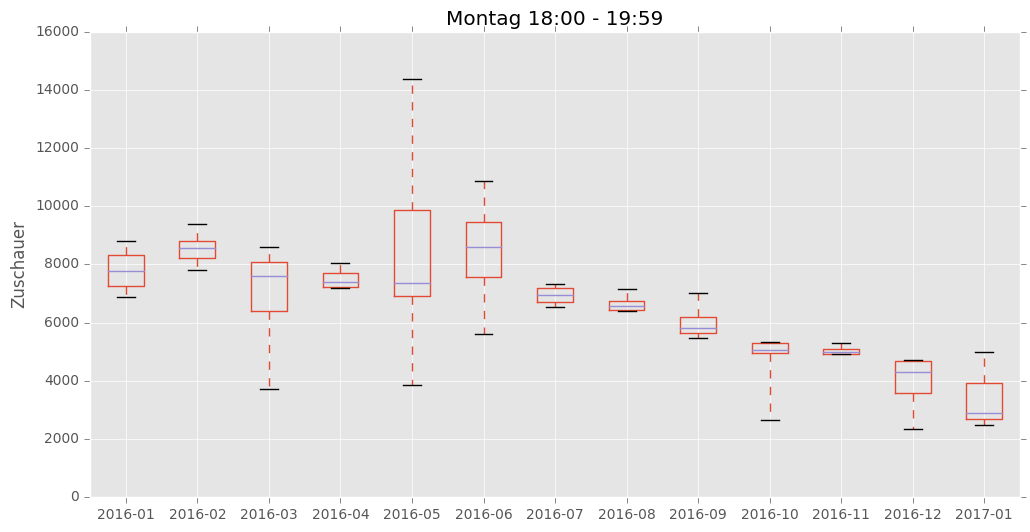

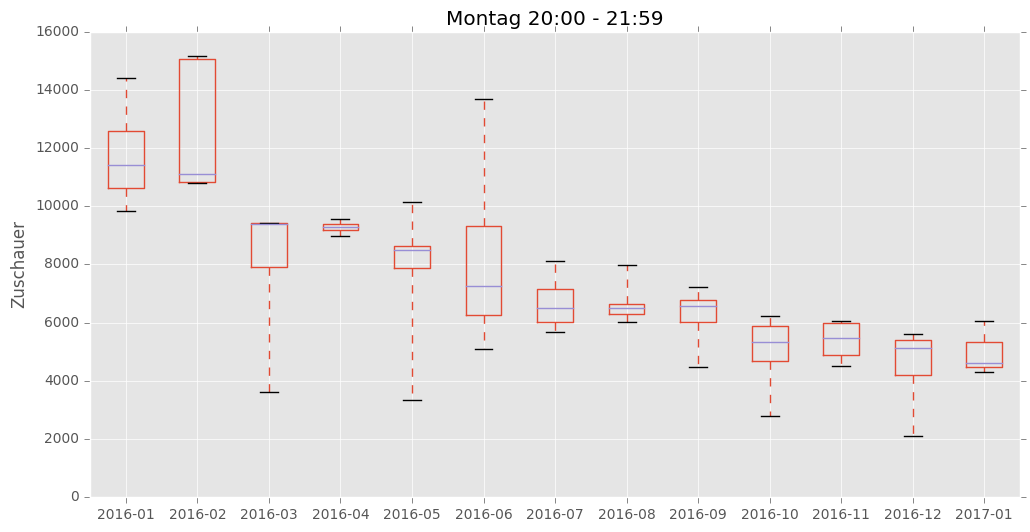

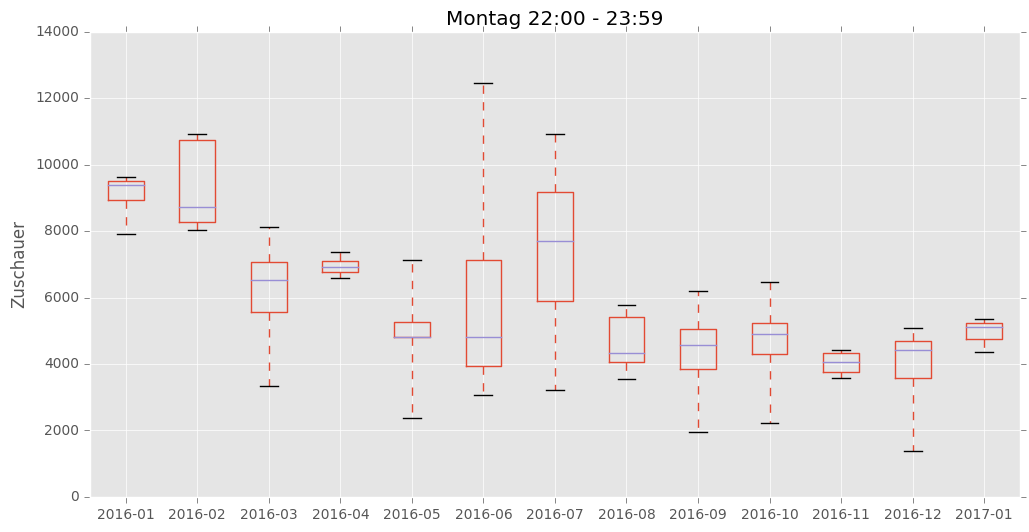

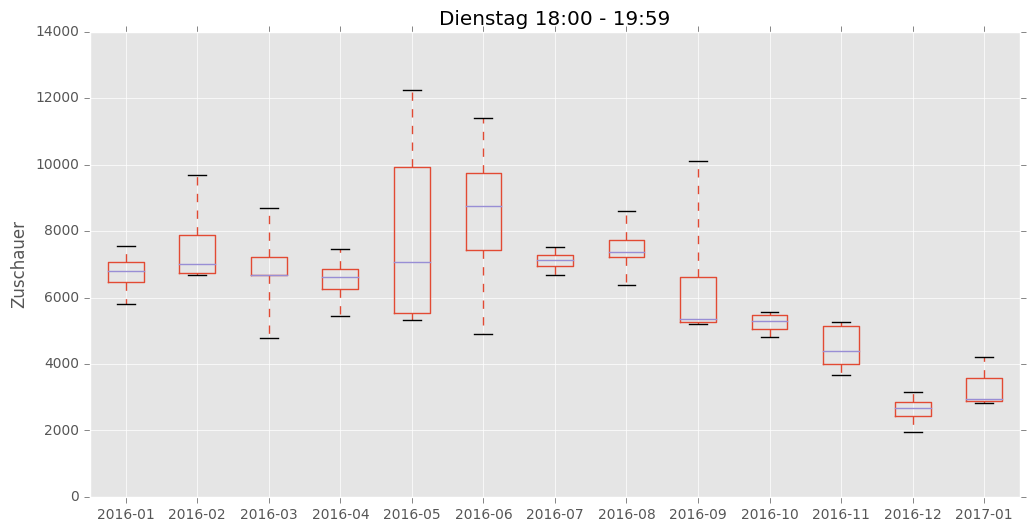

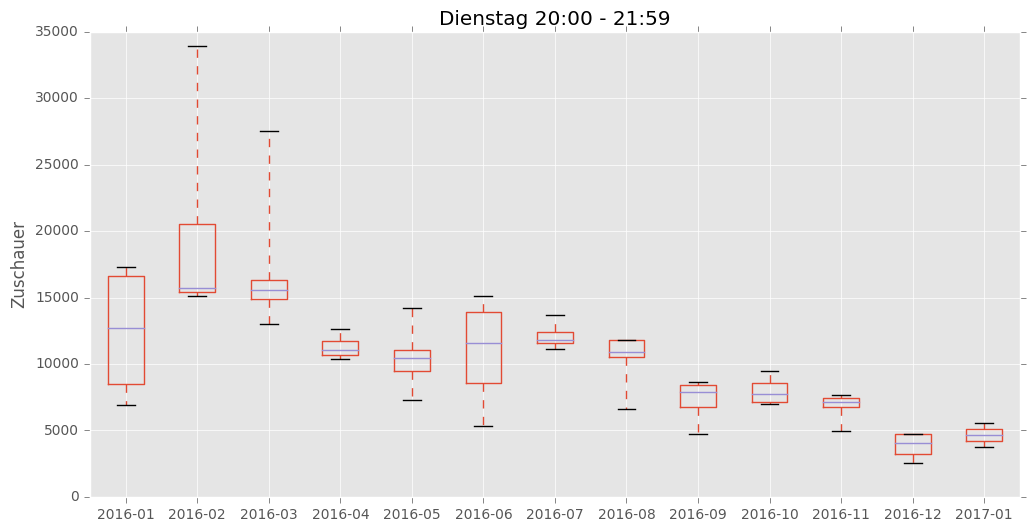

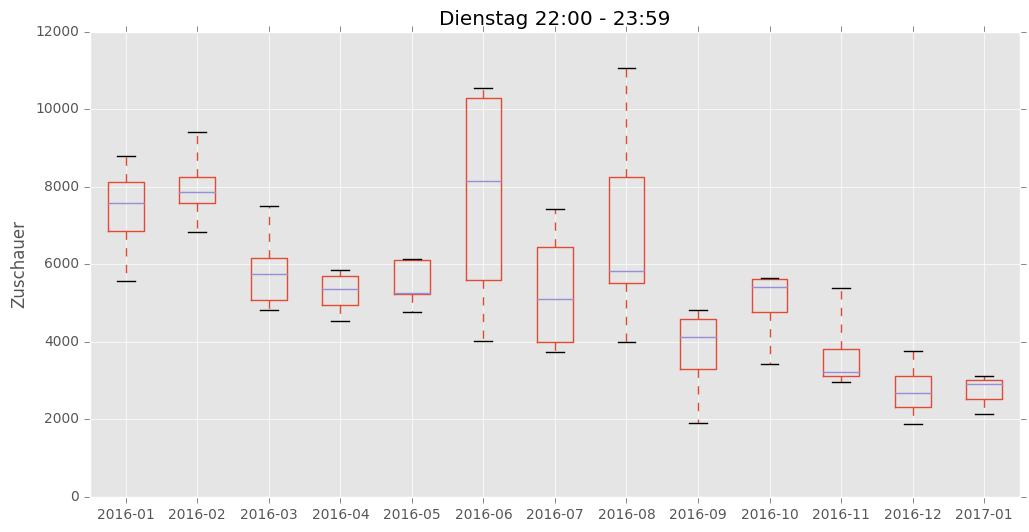

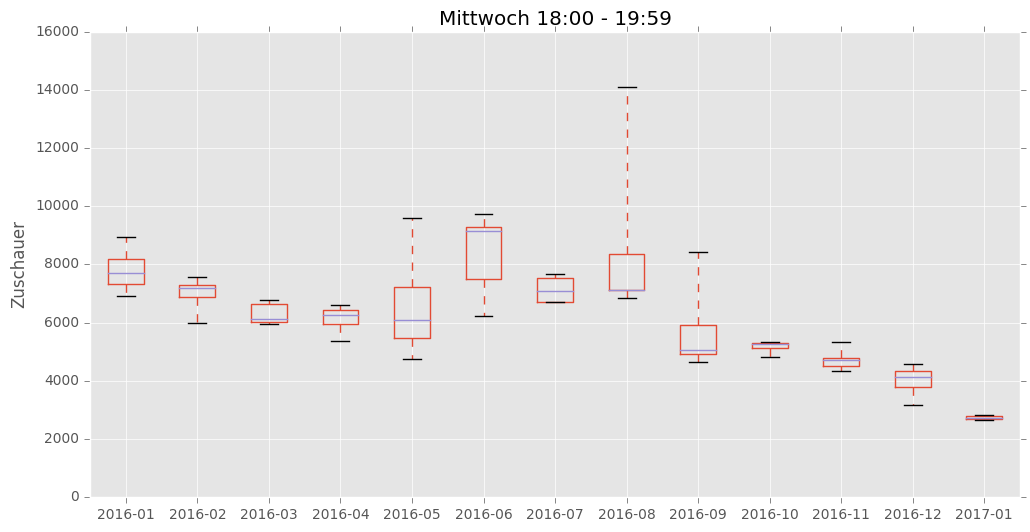

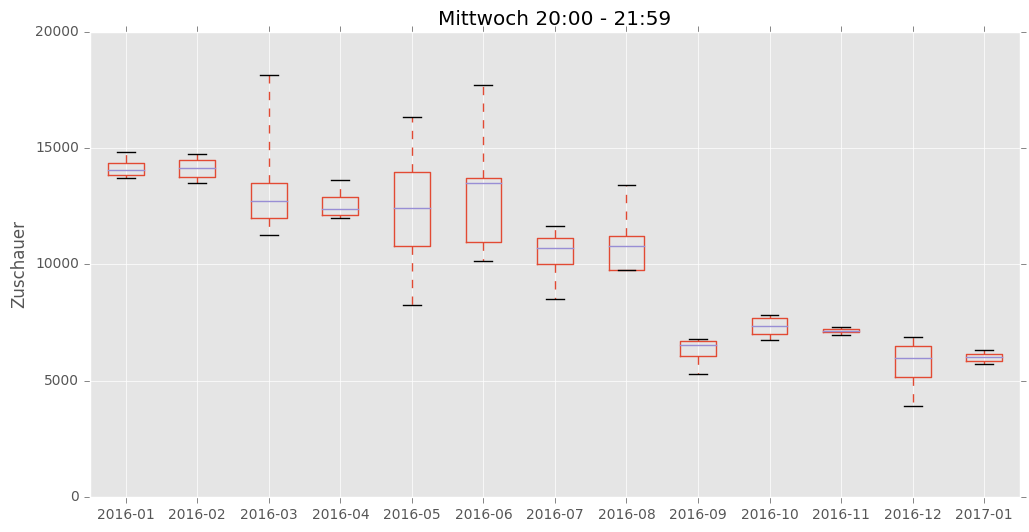

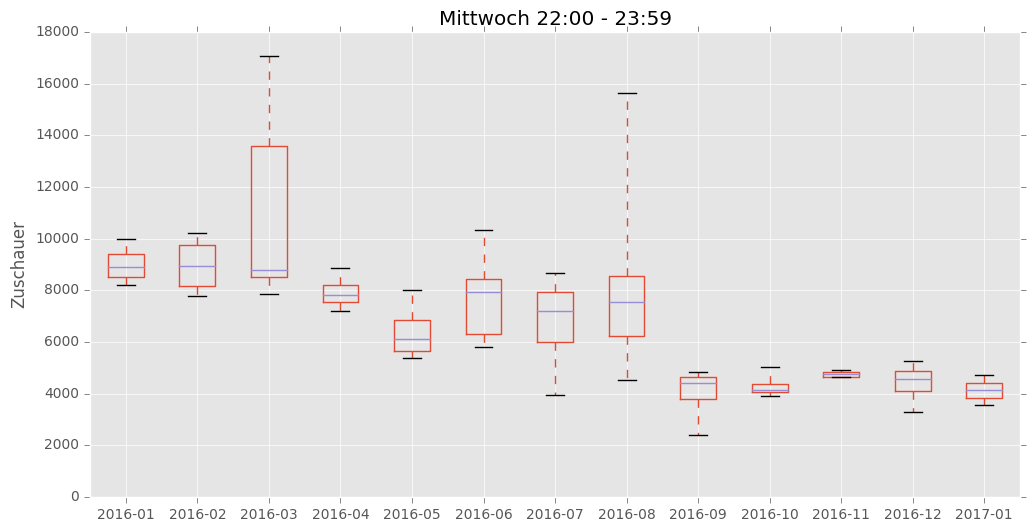

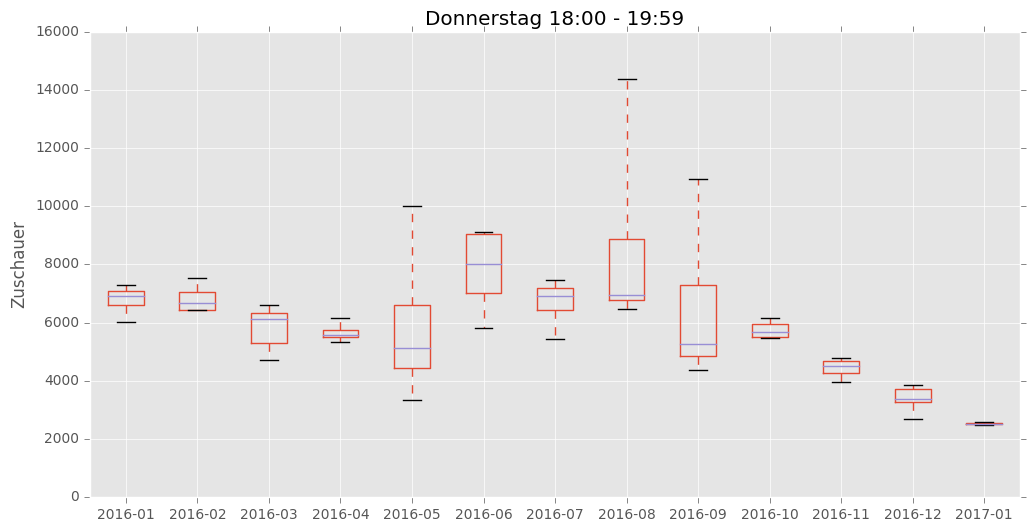

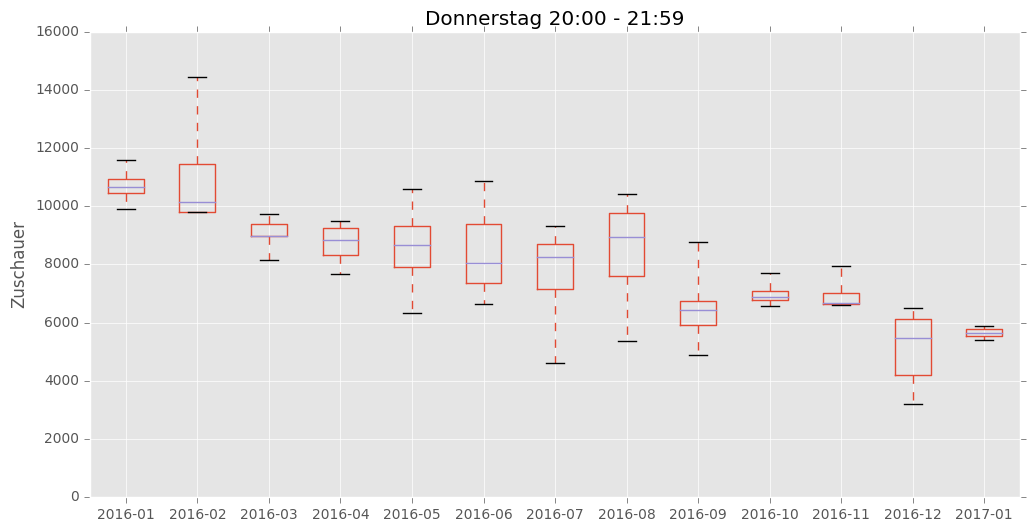

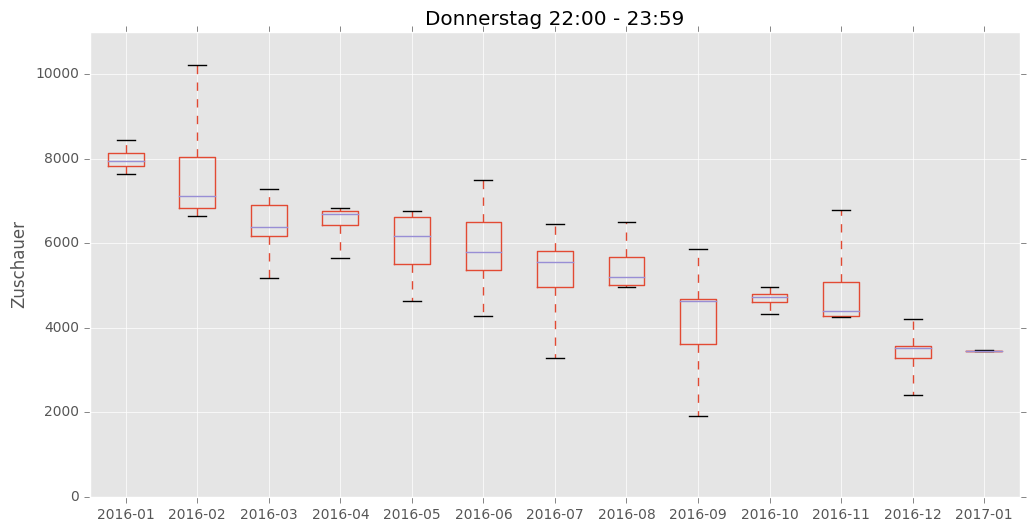

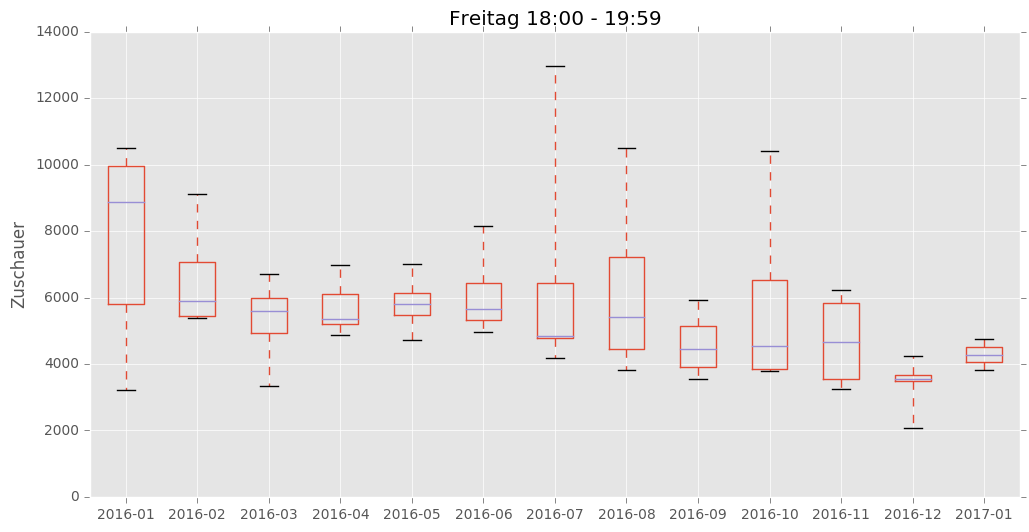

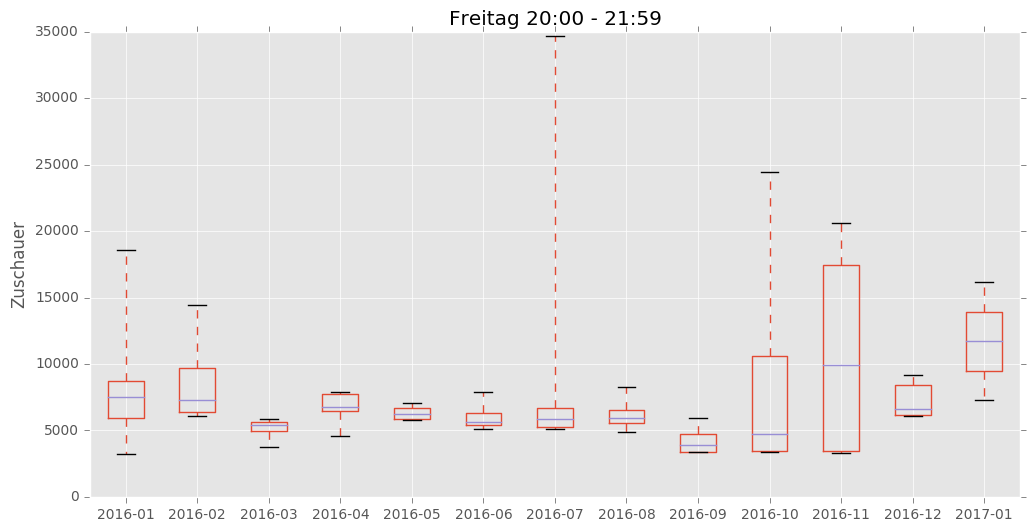

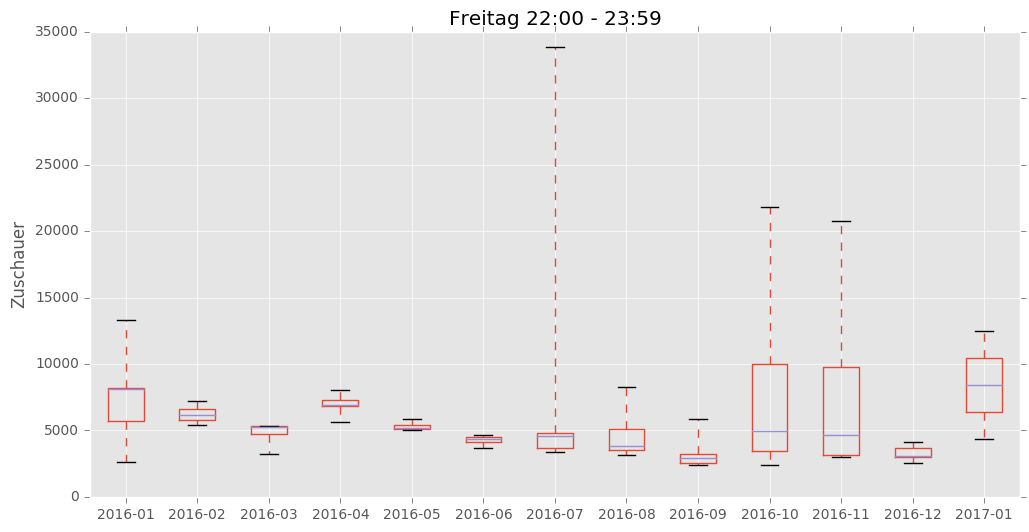

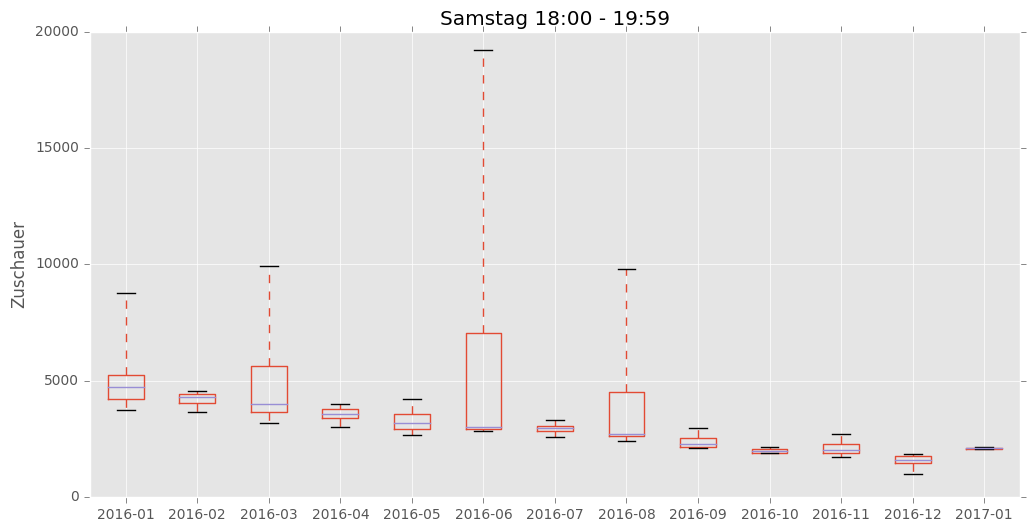

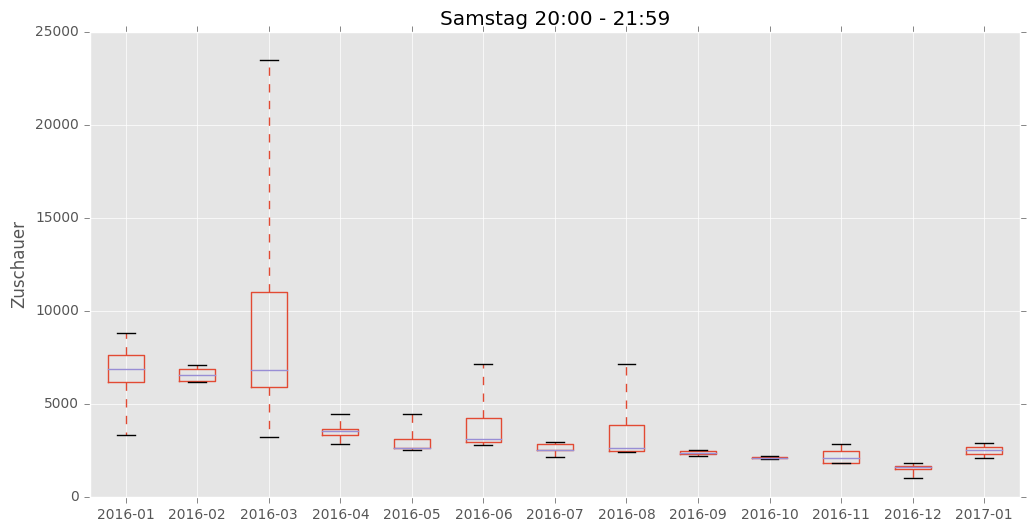

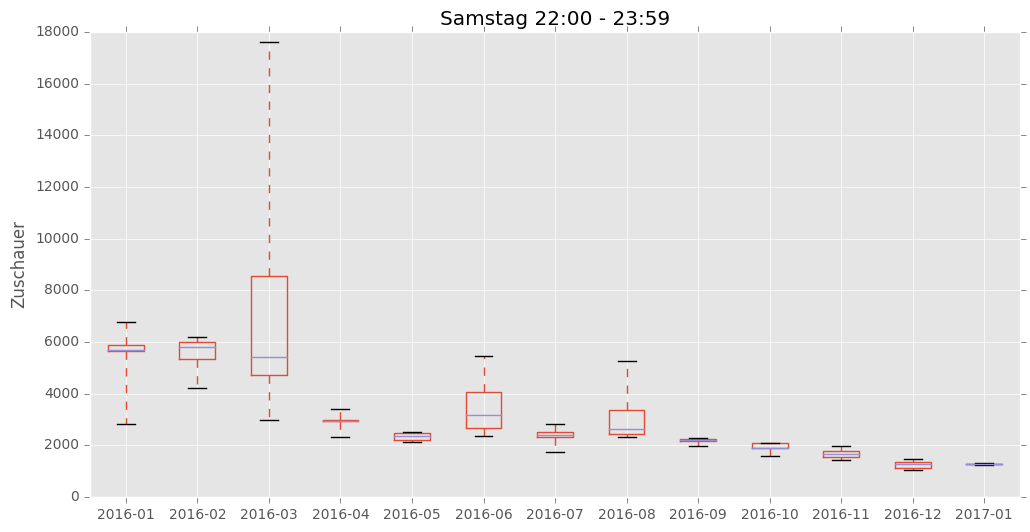

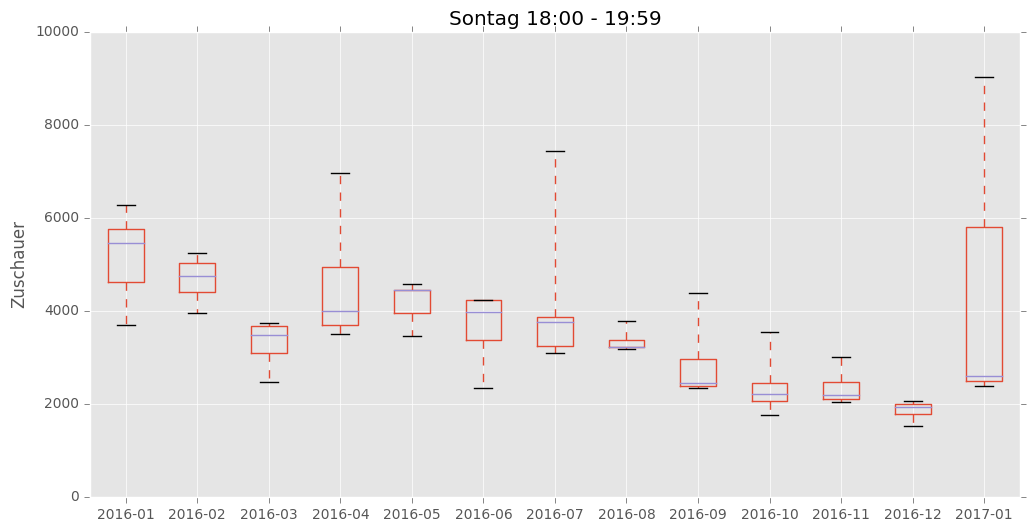

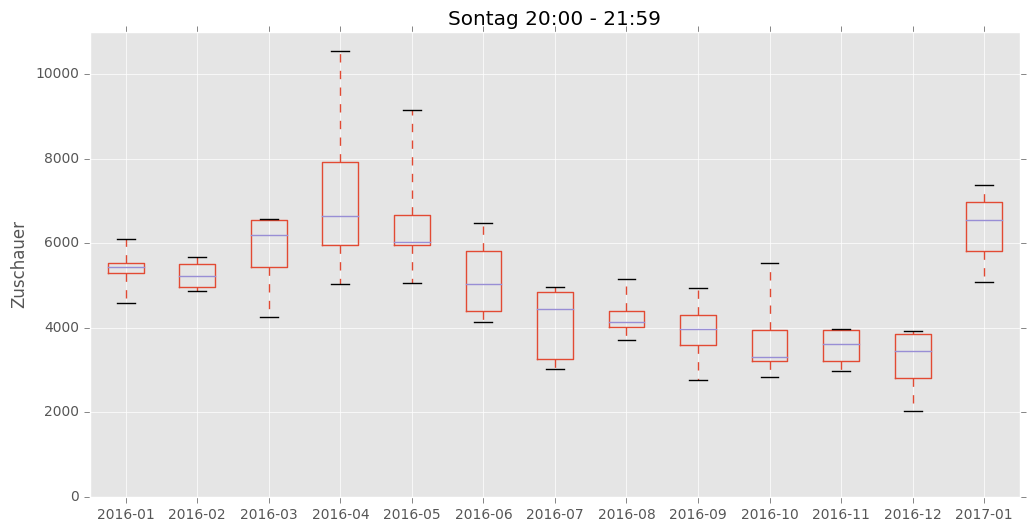

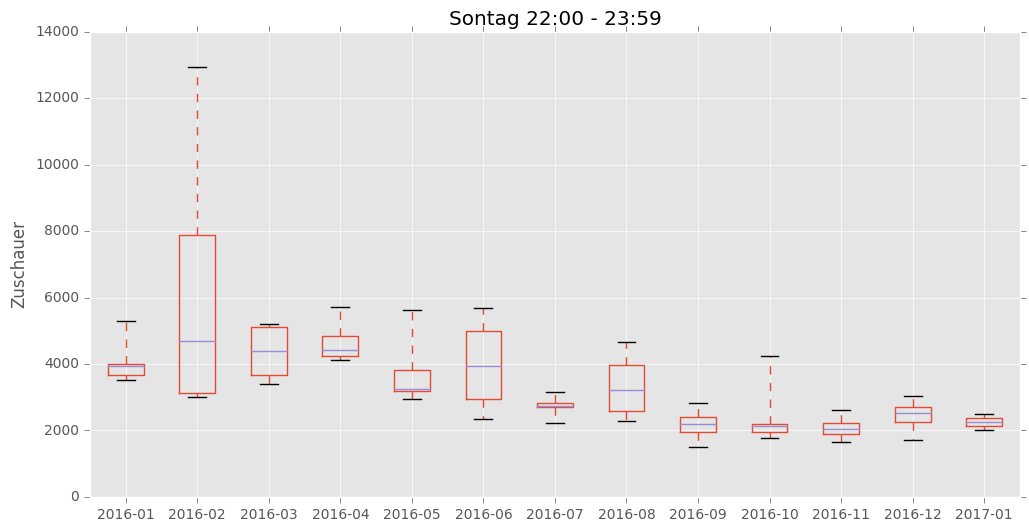

In [5]:
for i, value in enumerate(dataMonthly):
    weekdayStr = weekdayNames[i]
    for timeStr, data in sorted(value.iteritems()):
        plot = data.plot(kind='box', figsize=(12, 6), title='%s %s' % (weekdayStr, timeStr), whis=100)
        plot.set_ylabel('Zuschauer')
        plt.ylim(ymin=0)